## Visualizing Twitter hashtag co-occurence as a graph

The purpose of this notebook is to provide a basic example of how to retrieve data from the public Twitter API and visualize the results as a graph, including animation. It is based on this example: https://github.com/twitterdev/Twitter-API-v2-sample-code/blob/main/Recent-Tweet-Counts/recent_tweet_counts.py

## Setup

In this first section, we import the necessary packages and define functions that we will use later.

In [12]:
import os
import json

import requests
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')

In [3]:
# To set your environment variables in your terminal run the following line:
# export 'BEARER_TOKEN'='<your_bearer_token>'
bearer_token = os.environ.get("BEARER_TOKEN")

# Note that for this API endpoint, you only have access to recent dates. If your account has 
# academic access, you can query the /all endpoint for counts from the entire Tweet archive
search_url = "https://api.twitter.com/2/tweets/counts/recent"

In [4]:
def bearer_oauth(r):
    """
    Method required by bearer token authentication.
    """

    r.headers["Authorization"] = f"Bearer {bearer_token}"
    r.headers["User-Agent"] = "v2RecentTweetCountsPython"
    return r


def connect_to_endpoint(url, params):
    response = requests.request("GET", search_url, auth=bearer_oauth, params=params)
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()

## API queries to gather data

In this section, we define hashtags of interest, query the API, and save the resulting counts.

In [29]:
# You can change this to any hashtags or keywords you find interesting
hashtags_of_interest = [
    '#bitcoin',
    '#ethereum',
    '#hodl',
    '#dogecoin',
    '#crypto',
    '#nba',
    '#nfl',
    '#nhl',
    '#mlb',
    '#mls'
]

start_time = '2022-01-13T00:00:00.000Z'
end_time = '2022-01-19T00:00:00.000Z'
granularity = 'day'

In [30]:
# Grab all pairs of hashtags
n_hashtags = len(hashtags_of_interest)

pairs = set()

for i in range(n_hashtags):
    for j in range(n_hashtags):
        pairs.add((hashtags_of_interest[i], hashtags_of_interest[j]))

In [31]:
# Query the API for each pair
pairs = sorted(pairs)

results = []

for pair in pairs:
    curr_query = {
        'query': f"{pair[0]} {pair[1]}", #operators with spaces between are anded
        'granularity':  granularity,
        'start_time': start_time,
        'end_time': end_time
    }
    
    json_result = connect_to_endpoint(search_url, curr_query)
    results.append(json_result)

In [32]:
# Function for collating the retrieved JSON results into a single dataframe
def convert_results_to_df(results_list, pairs):
    results_dict = {
        'start': [],
        'end': [],
        'tweet_count': [],
        'first_hashtag': [],
        'second_hashtag': []
    }
    
    for r, p in zip(results_list, pairs):
        days = r['data']
        ht1, ht2 = p
        for d in days:
            results_dict['start'].append(d['start'])
            results_dict['end'].append(d['end'])
            results_dict['tweet_count'].append(d['tweet_count'])
            results_dict['first_hashtag'].append(ht1)
            results_dict['second_hashtag'].append(ht2)
    
    df = pd.DataFrame(results_dict)
    
    return df

In [33]:
df = convert_results_to_df(results, pairs)

In [34]:
# Save the co-occurence results to CSV for future use
df.to_csv('test_hashtags.csv', index=False)

## Visualizations

Here we experiment with different possible visualizations

### Matrix Visualization

First, we consider visualizing the matrix of co-occurence frequency directly

In [5]:
df = pd.read_csv('test_hashtags.csv')

In [7]:
grpd = df.groupby('start')

adj_matrices = []
for s, g in grpd:
    a = g.pivot('first_hashtag', 'second_hashtag', 'tweet_count')
    adj_matrices.append(a)

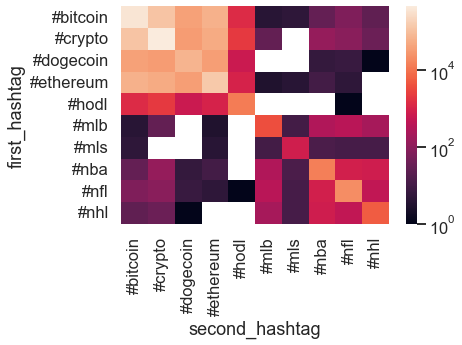

In [13]:
from matplotlib.colors import LogNorm

sns.heatmap(adj_matrices[0], norm=LogNorm())
plt.show()

### Network visualization

Here, we treat the co-occurence matrix as an adjacency matrix, import the graph into NetworkX, and build an animation of the network dynamics.

In [35]:
import networkx as nx

graphs = [nx.from_pandas_adjacency(a) for a in adj_matrices]

In [168]:
def draw_graph(adj_matrix):
    g = nx.from_pandas_adjacency(adj_matrix)
    
    weights = np.diag(adj_matrix)
    
    # Get rid of self loops because we'll use them for node size
    g.remove_edges_from(nx.selfloop_edges(g))
    node_sizes = 1000 * weights/np.mean(weights)
    edge_widths = []
    max_val = np.max(np.array(adj_matrix))

    # Compute widths for each edge
    for e in g.edges():
        edge_val = 50 * np.sqrt(adj_matrix.loc[e[0]][e[1]] / max_val)
        edge_widths.append(edge_val)

    # Draw the graph
    nx.draw_circular(
        g,
        with_labels=True,
        node_size=node_sizes,
        alpha=0.75,
        font_size=16,
        edge_color='red',
        node_color='orange',
        width=edge_widths
    )

The first visualization shows how hashtags co-occur on a single day, with the size of the nodes showing how much the single hashtag appeared and the widths of the edges showing how often the two connected hashtags appeared in the same Tweet.

<IPython.core.display.Javascript object>


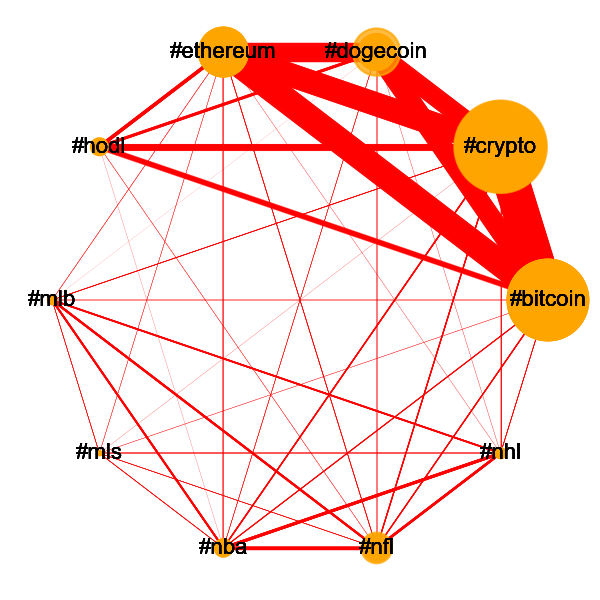

In [169]:
plt.figure(figsize=(6, 6))
draw_graph(adj_matrices[0])
plt.show()

We now animate the graph above over multiple days and save the result as a GIF

<IPython.core.display.Javascript object>


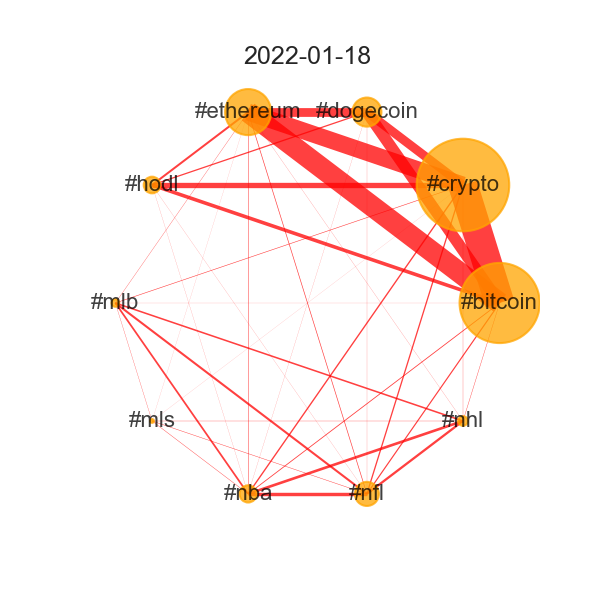

MovieWriter ImageMagick unavailable; using Pillow instead.


In [174]:
%matplotlib notebook

from matplotlib import animation
import time
from IPython import display

dates = [s.split('T')[0] for s in sorted(np.unique(df['start']))]

# Update func for animating the graph in time
def update_func(frame_num, ax):
    ax.clear()
    
    draw_graph(adj_matrices[frame_num])
    plt.title(dates[frame_num])
    time.sleep(0.5)

fig, ax = plt.subplots(figsize=(6, 6))
ani = animation.FuncAnimation(
    fig,
    update_func,
    frames=range(len(adj_matrices)),
    fargs=(ax,),
)

plt.show()

ani.save('test_animation.gif', writer='ImageMagick')

And just like that, we have our first graph visualization!